In [28]:
import torch
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from torchmetrics import PrecisionRecallCurve

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("CUDA available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
print("device name:", torch.cuda.get_device_name(0))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

CUDA available: True
device count: 1
device name: NVIDIA GeForce GTX 980M


device(type='cuda', index=0)

https://www.kaggle.com/code/colinlagator/pytorch-bert-multi-label/notebook

https://discuss.huggingface.co/t/download-models-for-local-loading/1963

Much of notebook is from: https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=-FWG7kBm372V

In [3]:
path_data_folder = Path().cwd().parent.parent / "data"
path_interim_folder = path_data_folder / "interim"
path_label_folder = path_data_folder / "processed" / "labels" / "labels_complete"

# load the labels.csv from the path_label_folder
df = pd.read_csv(path_label_folder / "labels.csv", dtype={"id": str})
df.head()

,id,pattern,token_count,update_date,label,para
0,1710.02907,"data, dataset",280,2022-04-21,0,"Experiment 2: In this set of experiments, we e..."
1,1811.11012,data,195,2022-04-21,0,This section of the technical report is focuse...
2,1811.11012,"data, dataset",70,2022-04-21,0,volunteers’ vehicles were mounted with BSM-bro...
3,1912.09582,dataset,13,2022-04-21,0,for small datasets–a case with Dutch book revi...
4,1912.09582,dataset,15,2022-04-21,1,Table 4: Sentiment Analysis accuracy scores on...


In [4]:
# create data loader -- inspired by https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
class ArxivDataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item]).lower()
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt', # Return PyTorch tensors
    )

    return {
      'texts': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [5]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=12)
df_train.head()

,id,pattern,token_count,update_date,label,para
99,2011.05411,dataset,89,2022-04-21,0,2. Local Computation: Once receiving the globa...
85,2011.00242,python,2,2022-04-21,0,PHP Python
31,2108.02756,dataset,140,2022-04-21,0,Inspired by the defense mechanism presented in...
14,2101.00522,dataset,104,2022-04-21,0,Table 3: The percentage of shift in pixel labe...
21,2104.09994,"publicly available, dataset",7,2022-04-21,0,Table 1 Public IoT network datasets.


In [6]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ArxivDataset(
    texts=df.para.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [7]:
# load the tokenizer
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')  # local

In [8]:
MAX_LEN = 512
BATCH_SIZE = 2

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

In [9]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [10]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])


In [11]:
data

{'texts': ['2. local computation: once receiving the global ml model from the server, the participants updates its current local ml model and then trains the updated model using the local dataset resided in the device. this step is operated at local nodes, and it requires end-users’ devices to install an fl client program to perform training algorithms such as federatedsgd and federated averaging, as well as to receive the global model updates and send the local ml model parameters from/to the server.',
  'php python'],
 'input_ids': tensor([[  102,   170,   205,  ...,     0,     0,     0],
         [  102,   375, 30121,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0, 0])}

## Build Model

In [12]:
PRE_TRAINED_MODEL_NAME = 'allenai/scibert_scivocab_uncased'

MAX_LEN = 512
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [13]:
class ArxivClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ArxivClassifier, self).__init__()
        self.encoder = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        self.dense_1 = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.dense_2 = torch.nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dense_1(pooled_output)
        pooled_output = torch.nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        output = self.dense_2(pooled_output)
        return output

In [14]:
model = ArxivClassifier(4)
model = model.to(DEVICE)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
data = next(iter(train_data_loader))
input_ids = data['input_ids'].to(DEVICE)
attention_mask = data['attention_mask'].to(DEVICE)

In [16]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1839, 0.2563, 0.3243, 0.2355],
        [0.2188, 0.2299, 0.3073, 0.2440],
        [0.2307, 0.2060, 0.3563, 0.2071],
        [0.2220, 0.2747, 0.2932, 0.2101]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
# try pr-auc curve with torchmetrics
# https://torchmetrics.readthedocs.io/en/v0.8.2/classification/precision_recall_curve.html
# https://torchmetrics.readthedocs.io/en/v0.8.2/classification/binned_precision_recall_curve.html

In [17]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

/home/tim/miniconda3/envs/arxiv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    DEVICE, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    DEVICE, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6974145607401927 accuracy 0.8119658119658121
Val   loss 0.32950213365256786 accuracy 0.9230769230769231

Epoch 2/10
----------
Train loss 0.7324514353182167 accuracy 0.8461538461538463
Val   loss 0.3138763438910246 accuracy 0.9230769230769231

Epoch 3/10
----------
Train loss 0.7529483499005437 accuracy 0.8461538461538463
Val   loss 0.2549473945982754 accuracy 0.9230769230769231

Epoch 4/10
----------
Train loss 0.5516829454960922 accuracy 0.8461538461538463
Val   loss 0.1842976410407573 accuracy 0.9230769230769231

Epoch 5/10
----------
Train loss 0.39444381175562737 accuracy 0.8717948717948719
Val   loss 0.33728070789948106 accuracy 0.9230769230769231

Epoch 6/10
----------
Train loss 0.1857807689967255 accuracy 0.9401709401709403
Val   loss 0.0068564958637580276 accuracy 1.0

Epoch 7/10
----------
Train loss 0.11227488704025745 accuracy 0.982905982905983
Val   loss 0.6060182137880474 accuracy 0.8461538461538463

Epoch 8/10
----------
Train loss 0.0

In [26]:
torch.tensor(history['train_acc'])

tensor([0.8120, 0.8462, 0.8462, 0.8462, 0.8718, 0.9402, 0.9829, 0.9915, 1.0000,
        1.0000], dtype=torch.float64)

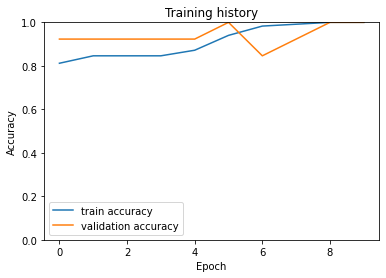

In [29]:
plt.plot(torch.tensor(history['train_acc']), label='train accuracy')
plt.plot(torch.tensor(history['val_acc']), label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Scratch

In [ ]:
text = "So we can solve the dual comparison problem (18) using any eﬃcient SVM solver, such as libsvm (Chang & Lin 2011). We used the R interface in the kernlab package (Karatzoglou et al. 2004), and our code is available in the rankSVMcompare package on Github."

print(text.lower())

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('/home/tvhahn/scibert_scivocab_uncased') # hpc
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')  # local

In [ ]:
tokenized_text = tokenizer.tokenize(text)
print(len(tokenized_text))
print(tokenized_text)

token_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
print(token_ids)

In [ ]:
encoding = tokenizer.encode_plus(
  text,
  max_length=512,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [ ]:
print(len(encoding['input_ids'][0]))
# encoding['input_ids'][0]

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
from transformers import AutoModel

# for hpc (need to manually download model)
# model = AutoModel.from_pretrained('/home/tvhahn/scibert_scivocab_uncased')

# for local computer
# model = AutoModel.from_pretrained('/home/tvhahn/scibert_scivocab_uncased')

In [ ]:
tokenized_text = tokenizer.tokenize(text)
print(len(tokenized_text))
print(tokenized_text)

In [ ]:
# remove stop words, etc
stop = stopwords.words('english')
text_tokens = word_tokenize(text)
tokens_without_sw = [word for word in text_tokens if not word in stop]

# text = text.lower()
# text = text.apply(lambda x: x.split(' '))
# text = text.apply(lambda x: [item for item in x if item not in stop])
# text = text.apply(lambda x: ' '.join(x))
# text = text.apply(lambda x: re.sub('[^A-Za-z\s]+', ' ', x))
# text = text.apply(lambda x: re.sub('\n', ' ', x))
# text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
# text = text.apply(lambda x: re.sub(r'^\s', '', x))
# text = text.apply(lambda x: re.sub(r'\s$', '', x))

In [ ]:
filtered_sentence = (" ").join(tokens_without_sw)
filtered_sentence

In [ ]:
tokenized_text = tokenizer.tokenize(text)
print(len(tokenized_text))
print(tokenized_text)

In [ ]:
text_tokens = tokenizer.batch_encode_plus(text, pad_to_max_length=True, max_length=512, return_tensors='pt')

In [ ]:
text_tokens['input_ids'].shape

In [ ]:
text_tokens